In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import pandas as pd
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats

In [2]:
# Load the California Housing dataset
housing = fetch_california_housing(as_frame=True)


df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df["target"] = housing.target

df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]
df = df.reset_index(drop=True)
X = df[housing.feature_names]
targets = df["target"]
# Always use transform_data function on X
scaler = StandardScaler().fit(np.array(targets).reshape(-1, 1))
targets = scaler.transform(np.array(targets).reshape(-1, 1)).flatten()

df["target"] = targets
data=df

In [3]:
import sys
sys.path.append('..')
from xDL.models.NAMLSS import NAMLSS

In [4]:
namlss = NAMLSS(
    "target ~  -1 + MLP(MedInc) + MLP(AveOccup) + MLP(AveBedrms)+ MLP(Population)+  MLP(Latitude):MLP(Longitude) + MLP(AveRooms)", 
    data=data, 
    family="Normal", 
    feature_dropout=0.0001
    )


--- Preprocessing ---


8it [00:03,  2.19it/s]
7it [00:00, ?it/s]


------------- Network architecture --------------
chosen distribution: Normal, distributional parameters: ['loc', 'scale']
MedInc -> MLP(feature=MedInc, n_params=12800) -> output dimension=2
AveOccup -> MLP(feature=AveOccup, n_params=12800) -> output dimension=2
AveBedrms -> MLP(feature=AveBedrms, n_params=12800) -> output dimension=2
Population -> MLP(feature=Population, n_params=12800) -> output dimension=2
Latitude_._Longitude -> MLP(feature=Latitude_._Longitude, n_params=12928) -> output dimension=2
AveRooms -> MLP(feature=AveRooms, n_params=12800) -> output dimension=2


In [5]:
def KL_Divergence(y_true, y_hat):
    t = tfd.Normal(loc=y_true, scale=tf.math.reduce_std(y_true))
    p = tfd.Normal(loc=y_hat, scale=tf.math.reduce_std(y_true))  
    kl = tf.reduce_mean(tfd.kl_divergence(t, p, allow_nan_stats=True))
    return kl

namlss.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=namlss.NegativeLogLikelihood, 
    metrics=KL_Divergence
    )

# Train the model
namlss.fit(namlss.training_dataset, epochs=100, validation_data=namlss.validation_dataset)

# Evaluate the model
loss = namlss.evaluate(namlss.validation_dataset)
print("Test Loss:", loss)

Epoch 1/100
16/16 [==============================] - 4s 40ms/step - loss: 1.8326 - KL_Divergence: 1.3123 - val_loss: 1.3892 - val_KL_Divergence: 1.1739
Epoch 2/100
16/16 [==============================] - 0s 24ms/step - loss: 1.4356 - KL_Divergence: 1.3831 - val_loss: 1.2169 - val_KL_Divergence: 0.8131
Epoch 3/100
16/16 [==============================] - 0s 23ms/step - loss: 1.3503 - KL_Divergence: 0.9869 - val_loss: 1.1584 - val_KL_Divergence: 0.6760
Epoch 4/100
16/16 [==============================] - 0s 24ms/step - loss: 1.2417 - KL_Divergence: 0.8222 - val_loss: 1.0836 - val_KL_Divergence: 0.5961
Epoch 5/100
16/16 [==============================] - 0s 24ms/step - loss: 1.1858 - KL_Divergence: 0.7665 - val_loss: 0.9985 - val_KL_Divergence: 0.5502
Epoch 6/100
16/16 [==============================] - 0s 24ms/step - loss: 1.1190 - KL_Divergence: 0.6911 - val_loss: 0.9296 - val_KL_Divergence: 0.5314
Epoch 7/100
16/16 [==============================] - 0s 23ms/step - loss: 1.0847 - KL_Di

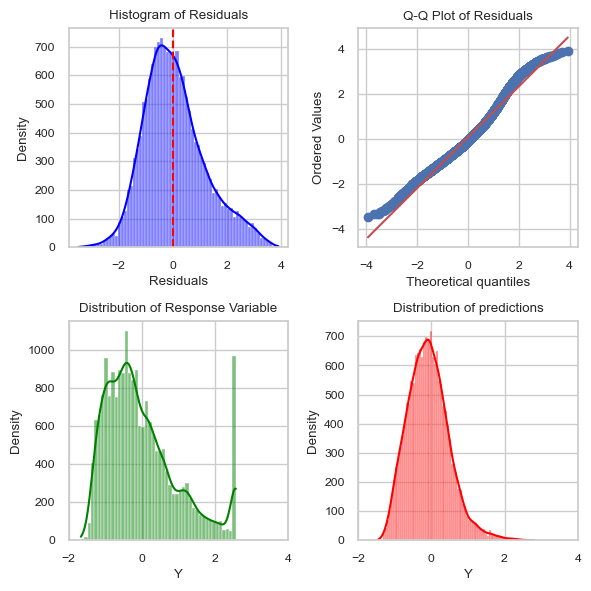

In [6]:
namlss.analytics_plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


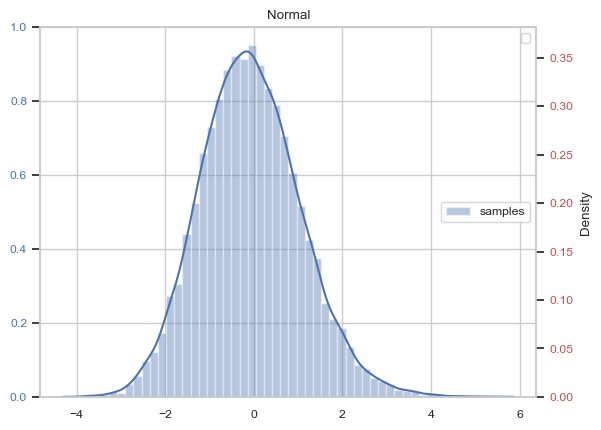

In [7]:
namlss.plot_dist()

100/100 [==============================] - 0s 1ms/step


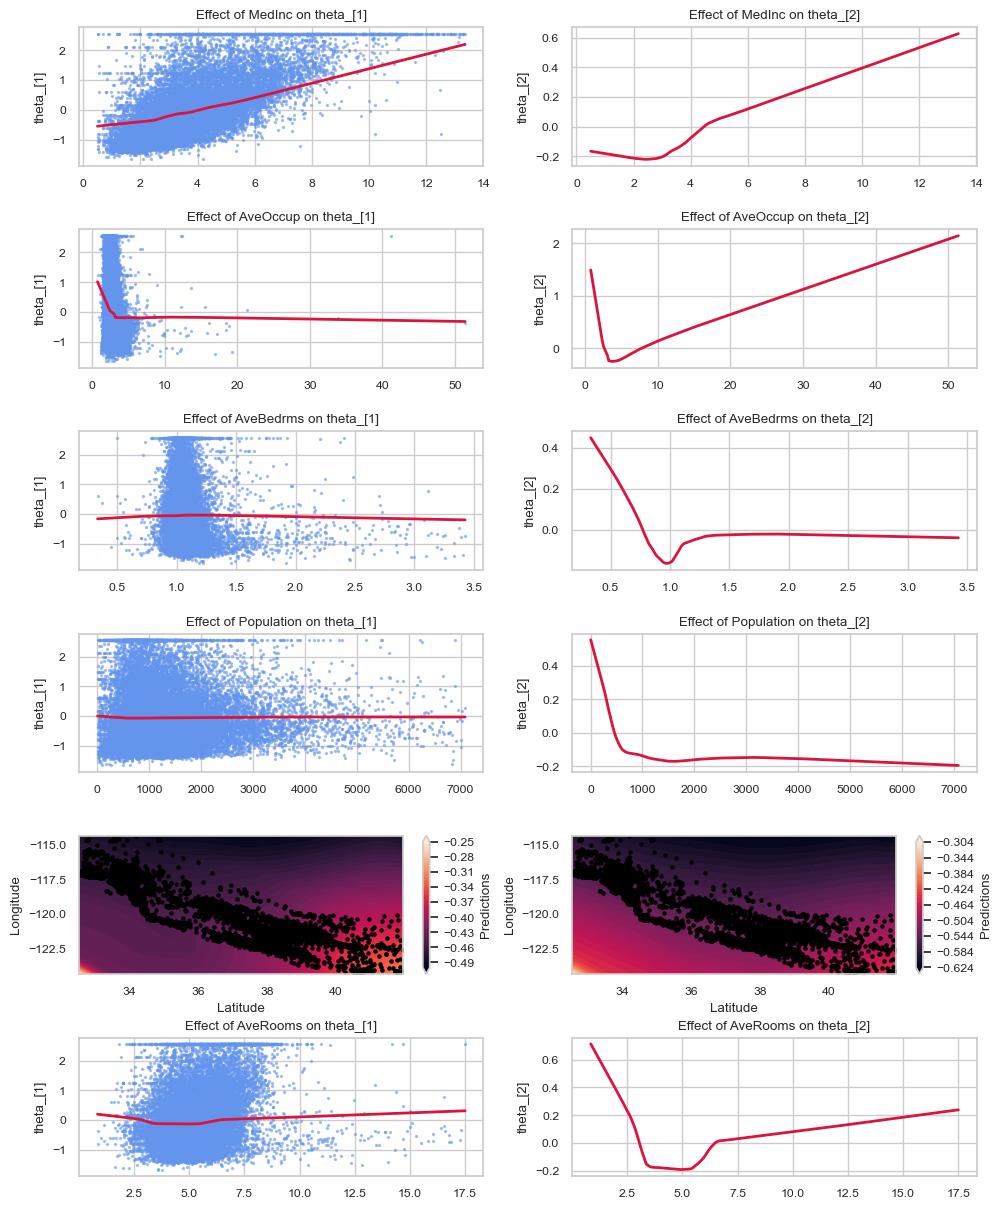

In [8]:
namlss.plot()